In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import json
import os
from os.path import join

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report, f1_score, roc_auc_score,roc_curve,auc

# Features Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#---Neural Network
from sklearn.neural_network import MLPClassifier

#---Multiclass Classification
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB, MultinomialNB


In [2]:
!pip3 install xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

In [3]:
## Runing on Colab
## /content/drive/MyDrive/git/cyberbullying/input/hate_speech/MMHS150K_GT.json
# dataset_directory = '/content/drive/MyDrive/git/cyberbullying/input/hate_speech' 
# img_txt_directory = '/content/drive/MyDrive/git/cyberbullying/input/hate_speech/img_txt' 
# img_resized_directory = '/content/drive/MyDrive/git/cyberbullying/input/hate_speech/img_resized' 
# splits_directory = '/content/drive/MyDrive/git/cyberbullying/input/hate_speech/splits' 

## Runing on Local
dataset_directory = 'D:\\git\\cyberbullying\\input\\hate_speech' 
# img_txt_directory = 'D:\\git\\cyberbullying\\input\\hate_speech\\img_txt' 
# img_resized_directory = 'D:\\git\\cyberbullying\\input\\hate_speech\\img_resized' 
# splits_directory = 'D:\\git\\cyberbullying\\input\\hate_speech\\splits' 

In [4]:
with open(join(dataset_directory,'MMHS150K_GT.json')) as json_file:
    hate_speech_data = json.load(json_file)

In [5]:
hate_speech = hate_speech_data.copy()

## Preprocessing Dataset

In [6]:
import nltk
import string
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [7]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hnbhu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hnbhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hnbhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\hnbhu\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Cleaning the texts

In [8]:
# def preprocessing(data):
#     stemmer = nltk.stem.RSLPStemmer()
#     all_stopwords = stopwords.words('english')
#     all_stopwords.remove('not')
#     corpus = []
#     for tweet in data:
#         review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
#         review = re.sub('RT', ' ', review)
#         review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
#         review = re.sub(r"https?", " ", review)
#         review = re.sub('[^a-zA-Z]', ' ', review)
#         review = review.lower()
#         review = review.split()
#         ps = PorterStemmer()
#         review = [ps.stem(word) for word in review if not word in set(all_stopwords) if len(word) > 2] 
#         review = ' '.join(review)
#         corpus.append(review)

#     return np.array(corpus)

In [9]:
# corpus = preprocessing(preprocess_df['tweet_text'])
# corpus.shape

In [10]:
# corpus

# Preprocessing

In [11]:
import operator
def get_max_item(a_dict):
  return max(a_dict.items(), key=operator.itemgetter(1))[0]
# get_max_item({'Religion': 3, 'Racist': 2})
# final_labels = [get_max_item(l) for l in labels]

In [12]:
get_max_item({'Religion': 1, 'Racist': 1})

'Religion'

In [13]:
def labels_to_single(labels):
  label_dict={}
  for l in labels:
    if l not in label_dict:
      label_dict[l] = 1
    else:
      label_dict[l] += 1
  return get_max_item(label_dict)

In [14]:
cb_ds = [[key, val['tweet_text'], val['labels_str'], labels_to_single(val['labels_str'])] 
              # 1 if sum(to_label(val['labels'])) == 3 else 0] 
             for key, val in hate_speech.items()]

## Train test split

In [15]:
X = [row[1] for row in cb_ds]
y = [row[3] for row in cb_ds]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(f'Data Split done.')

Data Split done.


## Word2vec

In [16]:
punctuations = "?:!.,;[]-"
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

In [17]:
def tokenize_and_remove_stop_words(text):
    #word_tokenizer = NLTKWordTokenizer()
    # inputs = ['']

    raw_tokens = word_tokenize(text)
    final_tokens = [token.lower() for token in raw_tokens
            if token not in punctuations and token not in stop_words]
    # print(final_tokens)
    return final_tokens


def lemmatize(words):
    return [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

def to_word2vec_vector(sent_items):
    model = Word2Vec(sent_items, min_count=1, vector_size=50, workers=3, window=3, sg=1)
    return model

def get_sentence_vectors(word2vec_model, sentence_tokens):
    res = []
    for sentence in sentence_tokens:  # TODO: fix two loops
        sentence_vectors = np.array([word2vec_model.wv[token] for token in sentence])
        mean = np.mean(sentence_vectors, axis=0)
        res.append(mean)

    return np.array(res)

def vectorize_by_wor2vec(text_instances):
  tokenized_items = []
  for ti in text_instances:
      tokens = tokenize_and_remove_stop_words(ti)
      tokens = lemmatize(tokens)
      # print(tokens)
      tokenized_items.append(tokens)

  #print(tokenized_items)
  model = to_word2vec_vector(tokenized_items)
  print(f'shape of word2vec model (vocabulary size) is: {model.cum_table.shape}')
  #print(model.cum_table)
  sen_vectors = get_sentence_vectors(model, tokenized_items)
  return sen_vectors

## Tranforming the dataset
Transforming the X_train and X_test dataset by using Word2vec. This datasets will be used to train the model and test against it.

In [18]:
# encode document
X_train = vectorize_by_wor2vec(X_train)
X_val  = vectorize_by_wor2vec(X_val)

print(f'Data Transformed.')

shape of word2vec model (vocabulary size) is: (228740,)
shape of word2vec model (vocabulary size) is: (68795,)
Data Transformed.


In [19]:
# X_train_w2v = vectorize_by_wor2vec(X_train[:3])
# print(f'Training model complete.')

# 3. Models

## 3.1 LinearSVC

In [20]:
# load the model from disk
# filename = 'SVM_model_onelabel.sav'
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

In [21]:
# %%time
# svm_clf = SVC(kernel='linear', C=1)
# modelSVC = svm_clf.fit(X_train, y_train)
# print(f'Training model complete.')

In [22]:
# # # Perform prediction on the training and validation data
# y_pred_train_svm_clf = svm_clf.predict(X_train)
# y_pred_val_svm_clf = svm_clf.predict(X_val)

# # # calculating accuracy score on training set
# print("Acc on training set: ", accuracy_score(y_train, y_pred_train_svm_clf))

# # # calculating accuracy score on val set
# print("Acc on validation set: ", accuracy_score(y_val, y_pred_val_svm_clf))

In [23]:
# # save the model to disk
# filename = 'SVM_model_onelabel.sav'
# pickle.dump(svm_clf, open(filename, 'wb'))

# 3.2 Neural Network

In [24]:
%%time
mlp_clf = MLPClassifier(solver='sgd',
                    alpha=1e-5,
                    hidden_layer_sizes=(10,),
                    random_state=1)
mlp_clf.fit(X_train, y_train)
print(f'Training model complete.')

Training model complete.
Wall time: 1min 44s


C:\Users\hnbhu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
# # Perform prediction on the training and validation data
y_pred_train_mlp_clf = mlp_clf.predict(X_train)
y_pred_val_mlp_clf = mlp_clf.predict(X_val)

# # calculating accuracy score on training set
print("Acc on training set: ", accuracy_score(y_train, y_pred_train_mlp_clf))

# # calculating accuracy score on val set
print("Acc on validation set: ", accuracy_score(y_val, y_pred_val_mlp_clf))

Acc on training set:  0.7796392397670577
Acc on validation set:  0.7170699149007175


# 3.3 XGBoost

In [26]:
%%time
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

print(f'Training model complete.')

C:\Users\hnbhu\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training model complete.
Wall time: 5min 34s


In [27]:
# Predicting the Test set results
y_pred = xgb_clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy is: %.4f\n" % accuracy)

Accuracy is: 0.7119



In [28]:
# # Perform prediction on the training and validation data
y_pred_train_xgb_clf = xgb_clf.predict(X_train)
y_pred_val_xgb_clf = xgb_clf.predict(X_val)

# # calculating accuracy score on training set
print("Acc on training set: ", accuracy_score(y_train, y_pred_train_xgb_clf))

# # calculating accuracy score on val set
print("Acc on validation set: ", accuracy_score(y_val, y_pred_val_xgb_clf))

Acc on training set:  0.8331692502794974
Acc on validation set:  0.7119305856832971


# 4. Pecision, recall, f-score, ROC and AUC charts

## 4.1 precision, recall, f-score

In [29]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()

In [30]:
# precision, recall, f-score for LinearSVC
# print(metrics.classification_report(y_val, y_pred_val_svm_clf,  digits=5))
# plot_confussion_matrix(y_val, y_pred_val_svm_clf)

F1 score is used as an evaluation measure as, when the data is skewed like in this case, where the number of hate speech tweets are very less, accuracy cannot be relied upon.

C:\Users\hnbhu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   Homophobe    0.04521   0.13456   0.06767       981
     NotHate    0.79017   0.91348   0.84736     23370
   OtherHate    0.33333   0.00063   0.00125      1597
      Racist    0.24000   0.00207   0.00411      2893
    Religion    0.00000   0.00000   0.00000        62
      Sexist    0.00000   0.00000   0.00000      1062

    accuracy                        0.71707     29965
   macro avg    0.23478   0.17512   0.15340     29965
weighted avg    0.65868   0.71707   0.66354     29965



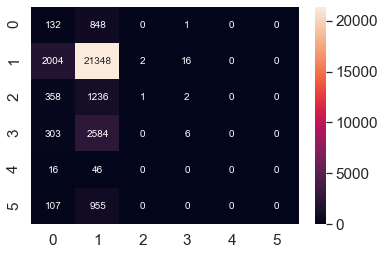

In [31]:
# precision, recall, f-score for neural network
print(metrics.classification_report(y_val, y_pred_val_mlp_clf,  digits=5))
plot_confussion_matrix(y_val, y_pred_val_mlp_clf)

              precision    recall  f1-score   support

   Homophobe    0.05882   0.00306   0.00581       981
     NotHate    0.78841   0.90116   0.84102     23370
   OtherHate    0.09756   0.01002   0.01817      1597
      Racist    0.08372   0.08780   0.08571      2893
    Religion    0.00000   0.00000   0.00000        62
      Sexist    0.00000   0.00000   0.00000      1062

    accuracy                        0.71193     29965
   macro avg    0.17142   0.16701   0.15845     29965
weighted avg    0.63010   0.71193   0.66535     29965



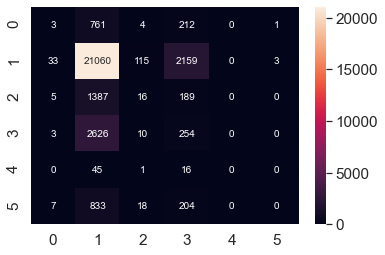

In [32]:
# precision, recall, f-score for XGBoost
print(metrics.classification_report(y_val, y_pred_val_xgb_clf,  digits=5))
plot_confussion_matrix(y_val, y_pred_val_xgb_clf)

## 4.2 ROC and AUC charts

In [33]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [34]:
# ROC curve for LinearSVC
# plot_roc_curve(y_val, y_pred_val_svm_clf)

In [38]:
# ROC curve for neural network
# plot_roc_curve(y_val, y_pred_val_mlp_clf)

In [39]:
# ROC curve for XGBoost
# plot_roc_curve(y_val, y_pred_val_xgb_clf)